<a href="https://colab.research.google.com/github/dahyun723/ESAA_1/blob/main/week7_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ch4.9-10 (267-295)

##09. 분류 실습 - 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객만족(santander Customer Satisfaction) 데이터 세트에 대한 고객 만족 여부를
XGBoost와 LightGBM을 활용해 예측해보겠습니다
산탄데르 고객 만족 예측 분석은 370개의 피처 -> 고객 만족 여부를 예측하는 것
TARGET = 1 : 불만이 있는 고객
TARGET = 0 : 만족한 고객
모델의 성능평가는 ROC-AUC(ROC곡선 영역)
대부분이 만족일것이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다는 ROC-AUC(ROC 곡선영역)가 더 적합



In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv("train.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [5]:
cust_df.info()
#피처의 타입과 Null값 알아보기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [7]:
cust_df.describe()
#피처의 값 분포를 간단히 확인

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

#피처 세트와 레이블 세트 분리 래이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt= y_train.count()
test_cnt= y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [10]:
#X_train, y_train 을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

###XGBoost 모델학습과 하이퍼 파라미터 튜닝
먼저 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해본다
사이킷런 래퍼인 XGBClassifier를 기반으로 학습
n_estimators은 500
early_stopping_rounds를 100으로 설정

성능 평가 기준이 ROC_AUC이므로 XGBClassifier의 eval_metric은 auc

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimator는 500으로, random state는 예제 수행 시마다 동일한 예측 결과 위해 설정.
# 성능 평가 지표를 auc로, 조기 중단 파라미터 설정
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156,
                        eval_metric="auc",
                        early_stopping_rounds=100)
# 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)],verbose=False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8417


In [12]:
# HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost 하이퍼 파라미터 튜닝 수행.

from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree',0.5,0.95),
                    'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [13]:
# 3Fold 교차검증 이용한 성능평가

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          colsample_bytree=search_space['colsample_bytree'],
                          learning_rate=search_space['learning_rate'],
                          early_stopping_rounds= 30,
                          eval_metric="auc")
  # 3개 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
  roc_auc_list = []
  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습/검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 평균 roc auc 계산 위해 list에 결과 담음. (early stopping 설정은 위에서.)
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)], verbose=False)
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1], average='macro')
    roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc-auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로, -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [14]:
# fmin()으로 최적의 하이퍼 파라미터 도출해보기
from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수 지정.
            trials=trials, rstate = np.random.default_rng(seed=30))

print('best:', best)

100%|██████████| 50/50 [16:18<00:00, 19.58s/trial, best loss: -0.8369805314638166]
best: {'colsample_bytree': 0.6848964687546426, 'learning_rate': 0.0709453695953271, 'max_depth': 6.0, 'min_child_weight': 5.0}


In [22]:
# 위에서 도출된 최적의 하이퍼 파라미터 기반으로 XGBClassifier 재학습, 테스트 데이터 세트에서 roc auc 측정

# n_estimator를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate = round(best['learning_rate'],5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'],5),
                        early_stopping_rounds=100,
                        eval_metric='auc')

# 학습 수행
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)], verbose = False)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8460


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

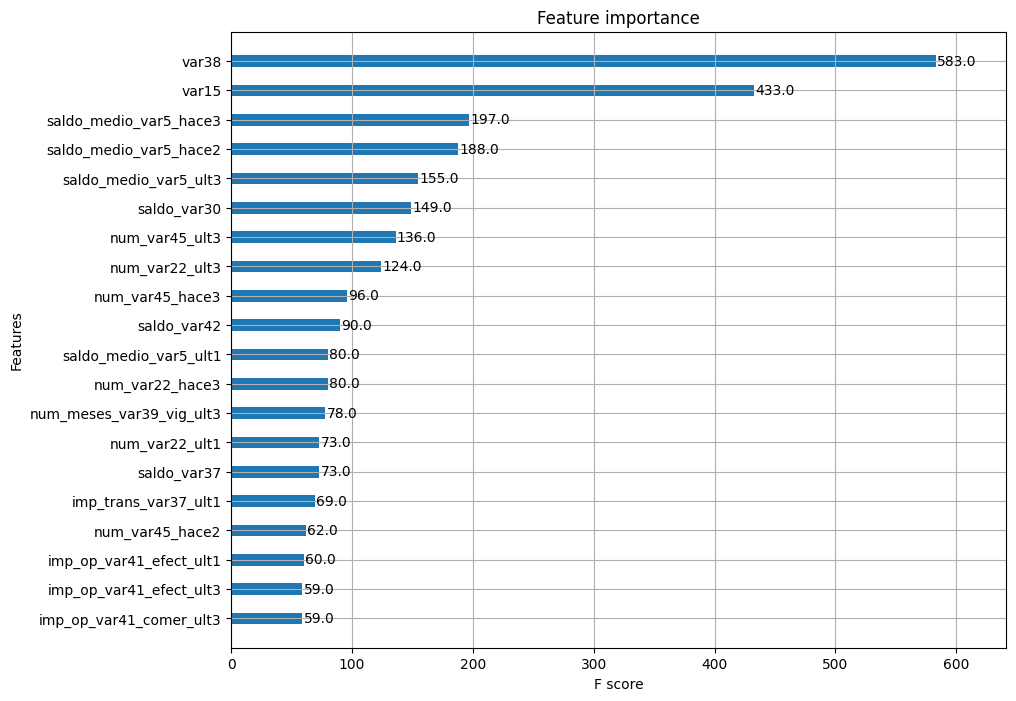

In [23]:
# 튜닝된 모델에서의 각 피처 중요도 시각화

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

###LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [24]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric='auc')

evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=evals)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [25]:
# HyperOpt로 하이퍼 파라미터 튜닝
# 튜닝 대상을 위한 검색 공간 설정
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves',32, 64, 1),
                     'max_depth': hp.quniform('max_depth',100,160,1),
                     'min_child_samples': hp.quniform('min_child_samples',60,100,1),
                     'subsample': hp.uniform('subsample',0.7,1),
                     'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)
                     }

In [26]:
warnings.filterwarnings("ignore", category=UserWarning)
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['subsample'],
                            learning_rate=search_space['learning_rate'],
                            #early_stopping_rounds=30,
                            metric='auc',
                            verbose=0)
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # 학습 수행(early stopping 설정은 위에서)
    lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold 로 계산된 roc-auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [27]:
# fmin()으로 최적 하이퍼 파라미터 도출
from hyperopt import fmin, tpe, Trials

trials = Trials()

In [28]:
# fmin() 호출, max_evals 지정 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
warnings.filterwarnings("ignore", category=UserWarning)

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, #최대 반복 횟수
            trials=trials, rstate=np.random.default_rng(seed=30))
print('best:', best)

100%|██████████| 50/50 [08:56<00:00, 10.73s/trial, best loss: -0.8355905239520475]
best: {'learning_rate': 0.03564213029580296, 'max_depth': 134.0, 'min_child_samples': 96.0, 'num_leaves': 32.0, 'subsample': 0.8545803136660588}


In [29]:

# 위에서 구한 하이퍼 파라미터를 이용하여 LightGBM 재학습, 테스트 데이터에서 ROC-AUC 평가
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'],5),
                          early_stopping_rounds=100,
                          eval_metric='auc')
# 학습 수행
lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.118614	valid_1's binary_logloss: 0.13475
[LightGBM] [Warning] Unknown parameter: eval_metric
ROC AUC: 0.8423


##10. 분류 실습 - 캐글 신용카드 사기 검출
사기 검출

이상 검출 데이터 셋은 레이틀 값이 극도로 불균형한 분포를 가지기 쉬움


In [33]:
!pip install imbalanced-learn

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 43, in create_package_set_from_installed
    package_set[name] = PackageDetails(dist.version

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [ ]:
# 사전 데이터 가공 수 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

In [ ]:
# get_clf_eval 함수
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# 로지스틱 회귀와 LightGBM 모델로 예측, 성능 평가

# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval()함수 이용해 평가
get_clf_eval(y_test, lr_pred, lr_pred_proba)

In [ ]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
# LightGBM 모델
from lightgbm import LGBMClassifier

# warnings.filterwarnings("ignore") > verbose = -1 설정!!

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False,verbose=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins =100, kde=True)
plt.show()

In [ ]:
# Amount를 표준 정규 분포 형태로 변환 후 로지스틱 회귀(선형 모델) 예측, 평가

from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardSclar를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1)) # 정규화
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.drop('Time', axis=1, inplace=True)
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  return df_copy

In [ ]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False,verbose=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


In [ ]:
# StandardScaler 대신 로그 변환 수행: 데이터 분포도 왜곡 시 상당 수준 개선
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
# 피처 로그 변환 후 예측성능 확인
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


In [ ]:
# 피처별 상관도 구하고 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
# 음의 상관관계가 높은 V14에 대해 이상치 제거

import numpy as np
def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  # IQR을 구하고, IQR에 1.5를 곱해 최대 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치로 설정, index 반환
  outlier_index =fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
# get_processed_df()에 이상치 추출, 삭제 로직 추가
# 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


In [ ]:
# smote의 fit_resample()로 증식
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())


In [ ]:
# 먼저 로지스틱 회귀 모델 학습, 성능평가

lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [ ]:
# LightGBM 모델을 SMOTE로 오버 샘플링한 데이터 세트로 학습/예측/평가
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)